In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# L04

In this notebook i will be solving partial diferantial equations using approximations to the dirivatvies provided by the FFT method. 

A derivative can be approximated by using the Fourier transform. From slide i have the equations:
$$ \hat{u}_x = j\omega \hat{u}  $$
$$ \hat{u}_{xx} = (j\omega)^2 \hat{u}  $$
$$ \hat{u}_{x*n} = (j\omega)^n \hat{u}  $$

where the hat denotes that the variable has been Fourier transformed: $\hat{u} = \mathcal{F}(u)$.

A derivative of a function can be found by:

$$ u' =  \mathcal{F}^{-1} (j\omega \mathcal{F}(u)) $$

## E 2.3

In this first experiment i will be solving the Korteweg-de Vries (KdV) equation:
$$ u_t + u_{xxx} - uu_x = 0 $$ 

I will be solving this equation on a large domain with the initial condition as: $u(x,0) = sech(x)$.

### Visualizing the derivative 

The derivative can be taken by doing a FFT transform:

Text(0.5, 1.0, "$u_0''(x)$")

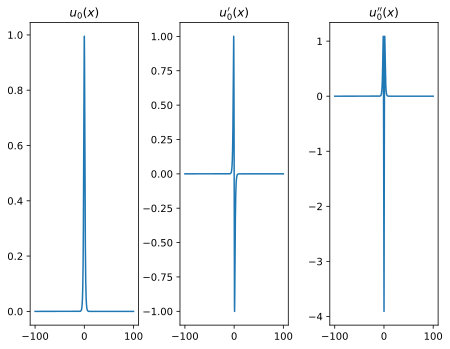

In [2]:
fig, axs = plt.subplots(1,3)
plt.tight_layout()

L = 100
n = L*10

xs = np.linspace(-L,L, num=n)
u0 = np.cosh(xs)**(-1)

u_hat = np.fft.fft(u0)
kappa = (2*np.pi / L)*np.arange(-n/2, n/2)
kappa = np.fft.fftshift(kappa)

df_hat = (1j*kappa)**1 * u_hat
ddf_hat = (1j*kappa)**2 * u_hat

du = np.fft.ifft(df_hat)
ddu = np.fft.ifft(ddf_hat)

axs[0].plot(xs, u0)
axs[0].set_title("$u_0(x)$")

axs[1].plot(xs, np.real(du))
axs[1].set_title("$u_0'(x)$")

axs[2].plot(xs, np.real(ddu))
axs[2].set_title("$u_0''(x)$")

### First attempt at solving the system

I now try to solve the system with the rhs in the Fourier domain. The right hand side is the Fourier domain is:
$$ \hat{u}_t = j\omega^3 \hat{u} + j\omega \hat{u}^2 $$

In [3]:
def rhs(t, u_hat, kappa):
    return (1j)*(kappa**3) * u_hat + (1j)*kappa*(u_hat**2)

In [4]:
sol = scipy.integrate.solve_ivp(rhs, t_span=(0,0.1), y0=u_hat, args=(kappa,))
t_cord = sol.t
y_cord = np.real(np.fft.ifft(sol.y,axis=0))

The solution can be seen plotted below and solution can also be seen in an animation.

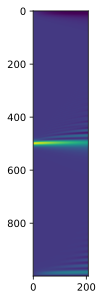

In [5]:
y_to_plot = y_cord[:,::10]
plt.imshow(y_to_plot)

In [6]:
from matplotlib import animation
from IPython.display import HTML, display

fig, ax = plt.subplots()

pl1 = ax.plot(xs,  y_to_plot[:,0])

def animate(i):
   pl1[0].set_ydata(y_to_plot[:,i])

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=y_to_plot.shape[1], interval=30)

output = HTML(ani.to_jshtml())
display(output)
plt.close()

Conclusion:
By solving the rhs in the Fourier domain and then using IFFT to tranfer the solution back to the normal domain I obtain a solution that only partially works. I have a theory that what goes wrong is that the Fourier is circular and thefrore wrappes around. This will be explored more in the next experiment.

### Second attempt

Now I solve the system where the rhs is in the normal domain and the derivatives are calculated by the Fourier method.

In [7]:
def rhs_2(t, u, kappa):
    u_hat = np.fft.fft(u)
    u_x_hat     = (1j*kappa)*u_hat
    u_xxx_hat   = ((1j*kappa)**3)*u_hat
    
    u_x = np.real(np.fft.ifft(u_x_hat))
    u_xxx = np.real(np.fft.ifft(u_xxx_hat))

    u_t = -u_xxx + u_x*u

    return u_t

In [8]:
sol_2 = scipy.integrate.solve_ivp(rhs_2, t_span=(0,0.1), y0=u0, args=(kappa,))
t_cord_2 = sol_2.t
y_cord_2 = sol_2.y

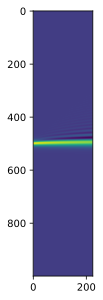

In [9]:
y_to_plot_2 = y_cord_2[:,::10]
plt.imshow(y_to_plot_2)

This time there is no odd effects at the bottom of the solution. This would the preferred way of solving the system.

## The wave equation

In this experiment i want to solve a simple linear PDE:
$$ u_t + c u_x = 0 $$
I have chosen the initial conditions to be $u_0 = exp(-x^2)$

Here i plot the initial condition and its derivative:

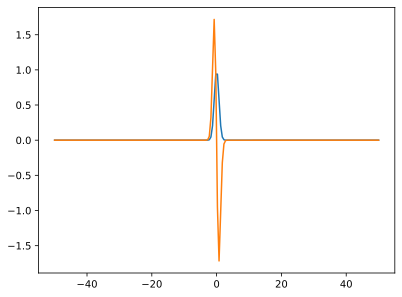

In [10]:
L = 50
n = 200

xs = np.linspace(-L,L, num=n)
u0 = np.exp(-xs**2)


u_hat = np.fft.fft(u0)
kappa = (np.pi*2/L)*np.arange(-n/2,n/2)
kappa = np.fft.fftshift(kappa)

du_hat = 1j*kappa*u_hat

du = np.real(np.fft.ifft(du_hat))

plt.plot(xs, u0)
plt.plot(xs,du)

I try again to solve the system in the Fourier domain. Here is setup the rhs and solve the system:

In [11]:
def rhs_wave(t, u_hat, kappa):
    return (0.1)*(-1j*kappa)*u_hat

sol = scipy.integrate.solve_ivp(rhs_wave, t_span=(0,1000), y0=u_hat, args=(kappa,))
t_cord = sol.t
y_cord = np.real(np.fft.ifft(sol.y,axis=0))

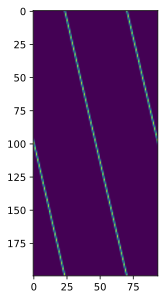

In [12]:
y_to_plot = y_cord[:,::10]
plt.imshow(y_to_plot)

In [13]:
from matplotlib import animation
from IPython.display import HTML, display

fig, ax = plt.subplots()


pl1 = ax.plot(xs,  y_to_plot[:,0])

def animate(i):
   pl1[0].set_ydata(y_to_plot[:,i])

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=y_to_plot.shape[1], interval=30)

output = HTML(ani.to_jshtml())
display(output)
plt.close()

It can be seen that the wave equation works as intened and pushes the initial condition to one side at a constant velocity. By solving the system in the Fourier domain the peak is seen to wrap around when it contacts one of the edges of the plot. This can either be seen as a failure or a feature depending on what the solution will be used for. 

## E 2.4

I now try to solve the Kuramoto-Sivashinsky (KS) equation:
$$ u_t + u_{xx} + u_{xxxx} + 0.5u_x^2 = 0 $$

with the initial condition of $u(x,0) = sech(x)$.

First i try by solving the system with the rhs in the Fourier domain:

In [14]:
L = 100
n = 3*L

xs = np.linspace(-L,L, num=n)
u0 = (np.cosh(xs))**(-1)

u_hat = np.fft.fft(u0)
kappa = (np.pi*2/L)*np.arange(-n/2,n/2)
kappa = np.fft.fftshift(kappa)

def rhs_ks(t,u_hat,kappa):
    return (-1)*(1j**2)*(kappa**2)*u_hat + (-1)*(1j**4)*(kappa**4)*u_hat + (-1/2)*(((1j**1)*(kappa**1)*(u_hat))**2)


sol = scipy.integrate.solve_ivp(rhs_ks, t_span=(0,10), y0=u_hat, args=(kappa,))
t_cord = sol.t
y_cord = np.real(np.fft.ifft(sol.y,axis=0))


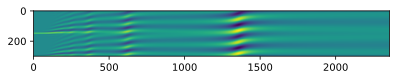

In [15]:
y_to_plot = y_cord[:,::10][:,:]
plt.imshow(y_to_plot)

This solution is again seen to have affects of being wrapped in the circular Fourier domain. I will now solve the system in the real domain:

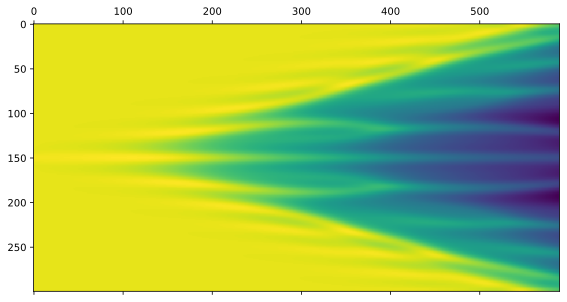

In [16]:
L = 100
n = 3*L

xs = np.linspace(-L,L, num=n)
u0 = (np.cosh(xs))**(-1)

kappa = (np.pi*2/L)*np.arange(-n/2,n/2)
kappa = np.fft.fftshift(kappa)

def rhs_ks_2(t,u,kappa):
    u_hat = np.fft.fft(u)
    
    u_x_hat     = (1j*kappa)*u_hat
    u_xx_hat    = ((1j*kappa)**2)*u_hat
    u_xxxx_hat  = ((1j*kappa)**4)*u_hat

    u_x     = np.real(np.fft.ifft(u_x_hat))
    u_xx    = np.real(np.fft.ifft(u_xx_hat))
    u_xxxx  = np.real(np.fft.ifft(u_xxxx_hat))

    return -u_xx - u_xxxx - (1/2)*(u_x**2)


sol_2 = scipy.integrate.solve_ivp(rhs_ks_2, t_span=(0,50), y0=u0, args=(kappa,))
t_cord_2 = sol_2.t
y_cord_2 = sol_2.y

plt.matshow(y_cord_2[:,::200])

By solving the rhs in the real domain I get a correct solution to the equation. Thefrore the conclusion for these experiments are: solving PDEs by calculating FFT-method for derivatives is doable but do not solve the rhs in the Fourier domain unless you are sure that it can be done and the solutions you get is useful for the problem that you are working on. One side effect to keep track of (there are possible more) is that the Fourier is wrapped and solutions in a wrapped space is not transfarable back to the real domain.